In [4]:
## Load libraries.
import json
import gzip
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn import preprocessing
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import string
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

% matplotlib inline
sns.set_style('whitegrid')

In [5]:
## Load data.
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 

def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 


df = getDF('Cell_Phones_and_Accessories_5.json.gz')
df.shape

(194439, 9)

## Detect Comment Topic

In [6]:
## Stopwords and stemmer.
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

## Function to remove stopwords, punctuation and stem text.
def clean_text(input_text):
    output_text = [stemmer.stem(word.lower().translate(None, string.punctuation)) \
                   for word in input_text.split() if word not in stop_words]
    return output_text

## Class to yield lines.
class LineSet(object):
    def __init__(self, input_lines):
        self.input_lines = input_lines
    def __iter__(self):
        for line in self.input_lines:
            yield clean_text(line)

## Generate word2vec model from reviews.
line_set = LineSet(df['reviewText'])
model = Word2Vec(line_set, size=200, min_count=8, window=7)

## Save and finalize model.
model.save('amazon2vec.bin')
model.init_sims(replace=True)

In [100]:
model = Word2Vec.load('amazon2vec.bin')

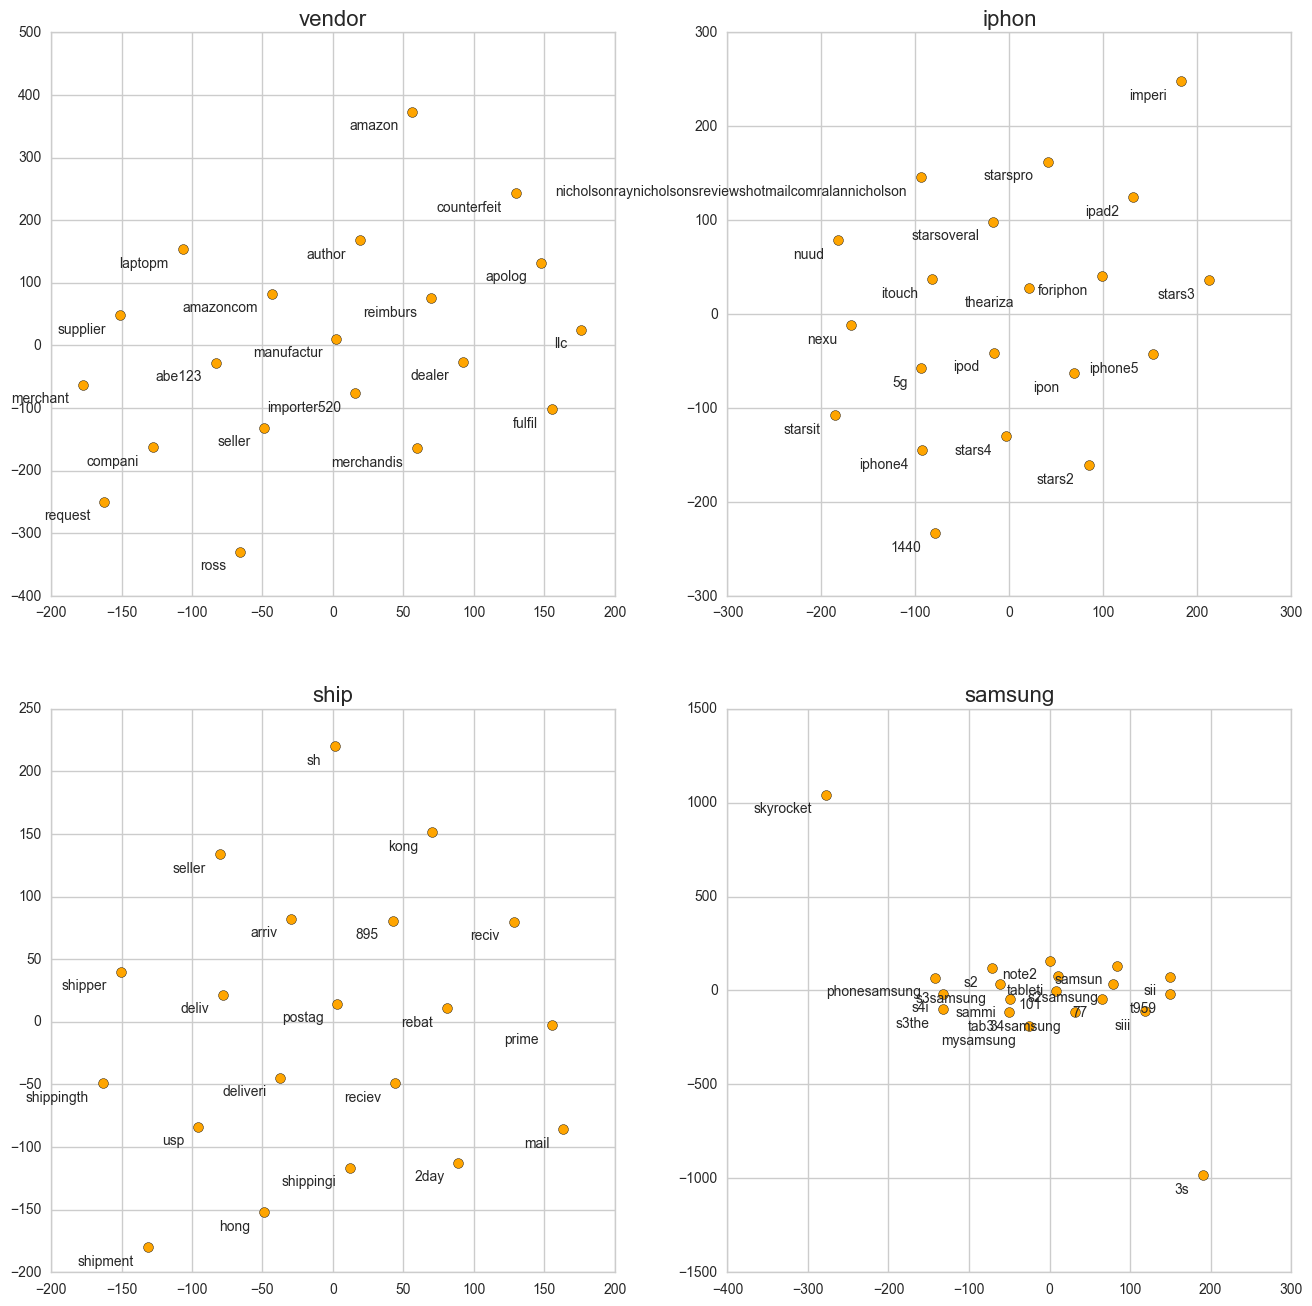

In [9]:
## Plot a couple of words.
test = ['vendor','iphon','ship','samsung']
tsne = TSNE(perplexity=80, n_components=2, init='pca', n_iter=5000)


## Plot.
plt.figure(1)
for t in xrange(len(test)):
    word_viz = np.array([model[word[0]] for word in model.most_similar(test[t], topn=20)])
    labels = [word[0] for word in model.most_similar(test[t], topn=20)]
    low_dim_embs = tsne.fit_transform(word_viz)
    
    plt.subplot(221 + t)

    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.title(test[t], size=16)
    plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1], s=50, c='orange')

    for label, x, y in zip(labels, low_dim_embs[:, 0], low_dim_embs[:, 1]):
         plt.annotate(label, 
                     xy = (x, y), xytext = (-10, -15), fontsize=10,
                     textcoords = 'offset points', ha = 'right', va = 'bottom')

In [107]:
df['tokens'] = df['reviewText'].map(clean_text)